In [1]:
# !pip install kaggle==1.5.12 tensorflow scikit-learn pandas matplotlib seaborn opencv-python pathlib numpy
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d proutkarshtiwari/adni-images-for-alzheimer-detection -p /content/ --unzip
print("Kaggle dataset downloaded and unzipped (if uncommented).")

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/proutkarshtiwari/adni-images-for-alzheimer-detection
License(s): apache-2.0
 98%|████████████████████████████████████████▎| 483M/491M [00:02<00:00, 268MB/s]
100%|█████████████████████████████████████████| 491M/491M [00:02<00:00, 236MB/s]
Kaggle dataset downloaded and unzipped (if uncommented).


In [2]:
# Cell 1: Setup and Imports
# ==========================

# --- Optional: Kaggle Setup (Uncomment if running on Kaggle/downloading) ---
# !pip install kaggle==1.5.12 tensorflow scikit-learn pandas matplotlib seaborn opencv-python pathlib numpy
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d proutkarshtiwari/adni-images-for-alzheimer-detection -p /content/ --unzip
# print("Kaggle dataset downloaded and unzipped (if uncommented).")

# --- Standard Imports ---
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from pathlib import Path
from collections import Counter
import time  # To time operations

# --- Scikit-learn Imports ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.utils import class_weight # No longer needed for balanced data

# --- TensorFlow Imports ---
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

print("--- Imports completed ---")
print(f"TensorFlow Version: {tf.__version__}")

--- Imports completed ---
TensorFlow Version: 2.17.1


In [3]:
# Cell 2: Configuration
# ======================
print("--- Configuring Paths and Parameters ---")

# --- Environment Setup ---
# << IMPORTANT >>: SET THESE PATHS ACCORDING TO YOUR ENVIRONMENT
#                 The code expects BASE_INPUT_DIR to contain 'train.csv'
#                 and the parent folder 'ADNI_IMAGES/png_images'.
# Kaggle Example: BASE_INPUT_DIR = '/kaggle/input/adni-images-for-alzheimer-detection'
# Colab Example: BASE_INPUT_DIR = '/content/' # Assuming dataset downloaded to /content/
# Local Example (adjust drive/user):
# BASE_INPUT_DIR = 'D:/adni_traininhig'
# BASE_INPUT_DIR = 'C:/Users/YourUser/Downloads/adni-images-for-alzheimer-detection'
BASE_INPUT_DIR = '/kaggle/input/adni-images-for-alzheimer-detection' # <<< SET YOUR PATH HERE

# << IMPORTANT >>: SET WHERE YOU WANT TO SAVE MODELS
# Colab Example (Drive): MODEL_SAVE_DIR = '/content/drive/MyDrive/AD_Models'
# Kaggle Example: MODEL_SAVE_DIR = '/kaggle/working/'
# Local Example: MODEL_SAVE_DIR = './adni_models'
MODEL_SAVE_DIR = '/kaggle/working/' # <<< SET YOUR PATH HERE

os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
print(f"Base Input Directory: {BASE_INPUT_DIR}")
print(f"Model Save Directory: {MODEL_SAVE_DIR}")

# --- Data Paths ---
CSV_PATH = os.path.join(BASE_INPUT_DIR, 'train.csv')
IMAGE_DIR_PARENT = os.path.join(BASE_INPUT_DIR, 'ADNI_IMAGES/png_images') # Parent dir containing class folders
print(f"CSV Path: {CSV_PATH}")
print(f"Image Directory Parent: {IMAGE_DIR_PARENT}")

# --- Model & Training Params ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 5
SEED = 42
INPUT_SHAPE = IMG_SIZE + (3,)
TEST_SPLIT_SIZE = 0.15 # Use 15% for the final test set
VALIDATION_SPLIT_SIZE = 0.20 # Use 20% *of the training data* for validation

# Phase 1 (Feature Extraction / Head Training)
EPOCHS_PHASE1 = 15          # Keep moderate, rely on EarlyStopping
LEARNING_RATE_PHASE1 = 1e-3 # Standard LR for the head

# Phase 2 (Fine-tuning)
EPOCHS_PHASE2 = 40          # Increase slightly, but rely on EarlyStopping (was 30)
LEARNING_RATE_PHASE2 = 1e-5 # Keep low LR for fine-tuning
FINE_TUNE_AT_LAYER = 150    # Fine-tune from this ResNet layer index onwards (approx. last block)

# Model Saving Paths
MODEL_CHECKPOINT_PATH = os.path.join(MODEL_SAVE_DIR, 'resnet50v2_adni_best.keras')
FINAL_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, 'resnet50v2_adni_final.keras')
print(f"Best model checkpoint path: {MODEL_CHECKPOINT_PATH}")
print(f"Final model save path: {FINAL_MODEL_PATH}")

# --- Class Mapping ---
diagnosis_mapping = {
    0: 'CN', 1: 'MCI', 2: 'EMCI', 3: 'LMCI', 4: 'AD'
}
class_names = list(diagnosis_mapping.values())
print(f"Class Names: {class_names}")

# --- Reproducibility ---
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
# os.environ['TF_DETERMINISTIC_OPS'] = '1' # Try for more determinism
print(f"Seeds set to: {SEED}")

print("--- Configuration complete ---")

--- Configuring Paths and Parameters ---
Base Input Directory: /kaggle/input/adni-images-for-alzheimer-detection
Model Save Directory: /kaggle/working/
CSV Path: /kaggle/input/adni-images-for-alzheimer-detection/train.csv
Image Directory Parent: /kaggle/input/adni-images-for-alzheimer-detection/ADNI_IMAGES/png_images
Best model checkpoint path: /kaggle/working/resnet50v2_adni_best.keras
Final model save path: /kaggle/working/resnet50v2_adni_final.keras
Class Names: ['CN', 'MCI', 'EMCI', 'LMCI', 'AD']
Seeds set to: 42
--- Configuration complete ---


In [4]:
# Cell 3: GPU Check
# ==================
print("\n--- GPU Check ---")
gpu_devices = tf.config.list_physical_devices('GPU')
print(f"Num GPUs Available: {len(gpu_devices)}")
if gpu_devices:
    print("GPU is available. TensorFlow should use it automatically.")
    try:
        for gpu in gpu_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(f"Could not set memory growth: {e}")
else:
    print("WARNING: No GPU detected. Training will be on CPU (might be very slow).")
print("--- GPU Check complete ---")


--- GPU Check ---
Num GPUs Available: 1
GPU is available. TensorFlow should use it automatically.
GPU memory growth enabled.
--- GPU Check complete ---



--- Loading and Exploring Metadata (EDA) ---
CSV loaded successfully from /kaggle/input/adni-images-for-alzheimer-detection/train.csv in 0.02 seconds.
Dataset shape: (20257, 2)

Dataset head:
     id_code  diagnosis
0    AD-3471          4
1    CN-1819          0
2  LMCI-0760          3
3  LMCI-1810          3
4    CN-4049          0

Checking for missing values...
id_code      0
diagnosis    0
dtype: int64
No missing values found in the metadata.

Added 'class_name' and 'diagnosis_str' columns.
   diagnosis class_name diagnosis_str
0          4         AD             4
1          0         CN             0
2          3       LMCI             3
3          3       LMCI             3
4          0         CN             0

Analyzing Class Distribution...


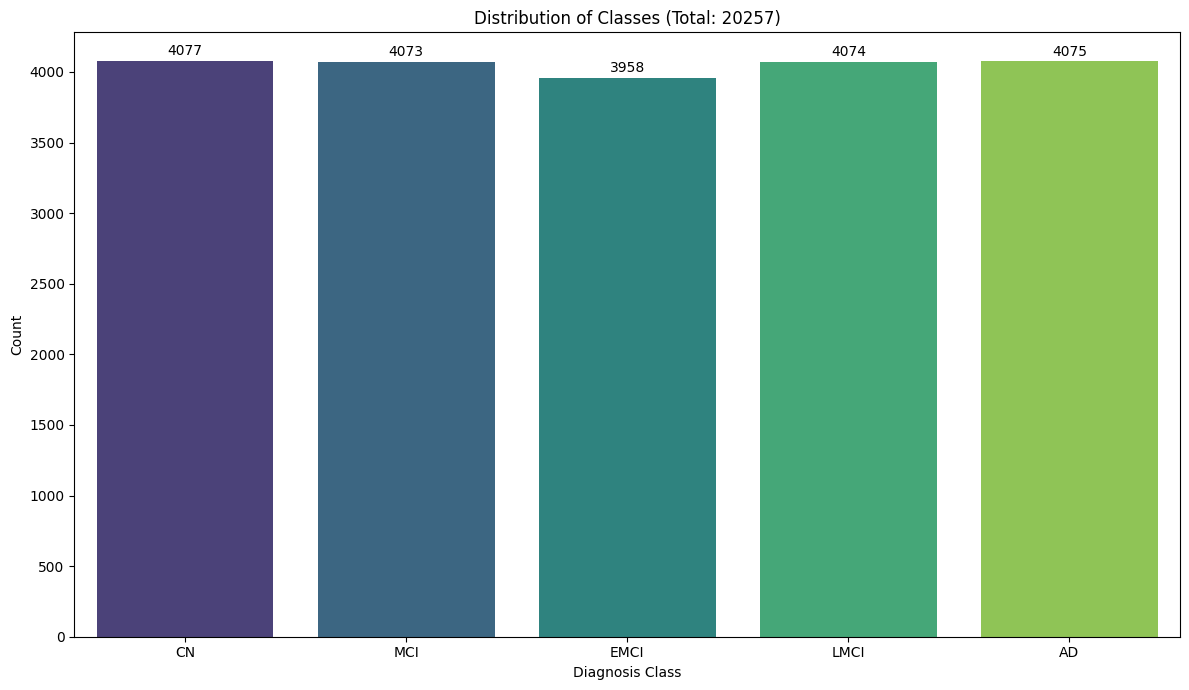


Exact Class Counts:
class_name
CN      4077
MCI     4073
EMCI    3958
LMCI    4074
AD      4075
Name: count, dtype: int64

Min samples per class: 3958
Max samples per class: 4077
Dataset classes appear well-balanced.
Class weights will NOT be used.
--- EDA complete ---


In [5]:
# Cell 4: Load and Explore Metadata (EDA)
# =========================================
print("\n--- Loading and Exploring Metadata (EDA) ---")
df = None # Initialize df
try:
    start_time = time.time()
    df = pd.read_csv(CSV_PATH)
    end_time = time.time()
    print(f"CSV loaded successfully from {CSV_PATH} in {end_time - start_time:.2f} seconds.")
    print(f"Dataset shape: {df.shape}")
    print("\nDataset head:")
    print(df.head())
except FileNotFoundError:
    print(f"ERROR: CSV file not found at {CSV_PATH}")
    print("Please ensure the dataset path is correct in the Configuration cell.")
except Exception as e:
    print(f"An error occurred while loading the CSV: {e}")

if df is not None:
    print("\nChecking for missing values...")
    print(df.isnull().sum())
    if df.isnull().sum().sum() > 0:
        print("Warning: Missing values found!")
        # Add handling here if needed (e.g., df = df.dropna())
    else:
        print("No missing values found in the metadata.")

    # Map diagnosis codes to human-readable names and create string version
    df['class_name'] = df['diagnosis'].map(diagnosis_mapping)
    df['diagnosis_str'] = df['diagnosis'].astype(str) # For ImageDataGenerator y_col
    print("\nAdded 'class_name' and 'diagnosis_str' columns.")
    print(df[['diagnosis', 'class_name', 'diagnosis_str']].head())

    # --- Enhanced EDA: Class Distribution ---
    print("\nAnalyzing Class Distribution...")
    plt.figure(figsize=(12, 7))
    class_counts = df['class_name'].value_counts().loc[class_names] # Ensure order matches class_names
    sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
    plt.title(f"Distribution of Classes (Total: {len(df)})")
    plt.xlabel("Diagnosis Class")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    # Add counts on top of bars
    for index, value in enumerate(class_counts.values):
        plt.text(index, value + 20, str(value), ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()

    print("\nExact Class Counts:")
    print(class_counts)
    # Check balance
    min_count = class_counts.min()
    max_count = class_counts.max()
    print(f"\nMin samples per class: {min_count}")
    print(f"Max samples per class: {max_count}")
    if max_count / min_count > 1.5: # Example threshold for imbalance
        print("Note: Some class imbalance detected, but seems relatively minor based on the plot.")
        print("Class weights will NOT be used as per the analysis.")
    else:
        print("Dataset classes appear well-balanced.")
        print("Class weights will NOT be used.")

else:
    print("\nDataFrame 'df' could not be loaded. Skipping further EDA and processing.")

print("--- EDA complete ---")

In [6]:
# Cell 5: Construct and Verify Image Paths
# ========================================
print("\n--- Constructing and Verifying Image Paths ---")
if df is not None:
    start_time = time.time()
    print("Constructing image paths...")
    df['image_path'] = df.apply(
        lambda row: os.path.join(IMAGE_DIR_PARENT, row['class_name'], f"{row['id_code']}.png"),
        axis=1
    )
    end_time = time.time()
    print(f"Image paths constructed in {end_time - start_time:.2f} seconds.")
    print("\nSample DataFrame with image paths:")
    print(df[['id_code', 'class_name', 'image_path']].head())

    # Verify paths (start with a sample)
    print("\nVerifying a sample of image paths...")
    num_to_check = min(200, len(df)) # Check a larger sample
    sample_paths = df['image_path'].sample(num_to_check, random_state=SEED)
    missing_samples = sample_paths[~sample_paths.apply(os.path.exists)]

    if not missing_samples.empty:
         print(f"WARNING: {len(missing_samples)} out of {num_to_check} sample image paths do not exist. Examples:")
         print(missing_samples.head())
         print("\nVerifying ALL paths (this might take time)...")
         start_time_full = time.time()
         path_exists = df['image_path'].apply(os.path.exists)
         missing_df = df[~path_exists]
         end_time_full = time.time()
         print(f"Full path verification took {end_time_full - start_time_full:.2f} seconds.")
         if not missing_df.empty:
             print(f"ERROR: Found {len(missing_df)} total missing image paths!")
             print("Example missing paths:")
             print(missing_df[['id_code', 'image_path']].head(10))
             # Raising error as missing images will break training
             raise FileNotFoundError(f"Missing image files found. Check IMAGE_DIR_PARENT: '{IMAGE_DIR_PARENT}' and CSV data integrity.")
         else:
            print("Full verification passed. All constructed image paths are valid.")
    else:
        print(f"All {num_to_check} sample image paths are valid.")
        # Assuming if a decent sample is valid, all are likely valid (can add full check if needed)
        # print("Assuming all paths are valid based on the sample check.")

else:
    print("DataFrame 'df' not loaded. Skipping path construction and verification.")

print("--- Path Verification complete ---")


--- Constructing and Verifying Image Paths ---
Constructing image paths...
Image paths constructed in 0.21 seconds.

Sample DataFrame with image paths:
     id_code class_name                                         image_path
0    AD-3471         AD  /kaggle/input/adni-images-for-alzheimer-detect...
1    CN-1819         CN  /kaggle/input/adni-images-for-alzheimer-detect...
2  LMCI-0760       LMCI  /kaggle/input/adni-images-for-alzheimer-detect...
3  LMCI-1810       LMCI  /kaggle/input/adni-images-for-alzheimer-detect...
4    CN-4049         CN  /kaggle/input/adni-images-for-alzheimer-detect...

Verifying a sample of image paths...
All 200 sample image paths are valid.
--- Path Verification complete ---


In [7]:
# Cell 5.5: Create Train/Test Split
# ==================================
print("\n--- Creating Train/Test Split ---")

if df is not None:
    # Ensure 'diagnosis_str' exists for stratification
    if 'diagnosis_str' not in df.columns:
        print("ERROR: 'diagnosis_str' column not found. Please run Cell 4 again.")
        df_train, df_test = None, None # Prevent further execution
    else:
        print(f"Splitting data: {(1-TEST_SPLIT_SIZE)*100:.1f}% train, {TEST_SPLIT_SIZE*100:.1f}% test")
        df_train, df_test = train_test_split(
            df,
            test_size=TEST_SPLIT_SIZE,
            random_state=SEED,
            stratify=df['diagnosis_str'] # Stratify to maintain class proportions
        )
        print(f"Original DataFrame shape: {df.shape}")
        print(f"Training DataFrame shape: {df_train.shape}")
        print(f"Test DataFrame shape: {df_test.shape}")

        # Verify stratification (optional)
        print("\nTrain Class Distribution:")
        print(df_train['class_name'].value_counts(normalize=True).sort_index())
        print("\nTest Class Distribution:")
        print(df_test['class_name'].value_counts(normalize=True).sort_index())
else:
    print("DataFrame 'df' not loaded. Cannot create split.")
    df_train, df_test = None, None

print("--- Train/Test Split complete ---")


--- Creating Train/Test Split ---
Splitting data: 85.0% train, 15.0% test
Original DataFrame shape: (20257, 5)
Training DataFrame shape: (17218, 5)
Test DataFrame shape: (3039, 5)

Train Class Distribution:
class_name
AD      0.201185
CN      0.201243
EMCI    0.195377
LMCI    0.201127
MCI     0.201069
Name: proportion, dtype: float64

Test Class Distribution:
class_name
AD      0.201053
CN      0.201382
EMCI    0.195459
LMCI    0.201053
MCI     0.201053
Name: proportion, dtype: float64
--- Train/Test Split complete ---



--- Defining Image Preprocessing Function ---
Preprocessing function defined.

Testing preprocessing function...
Processing sample image: /kaggle/input/adni-images-for-alzheimer-detection/ADNI_IMAGES/png_images/AD/AD-3471.png


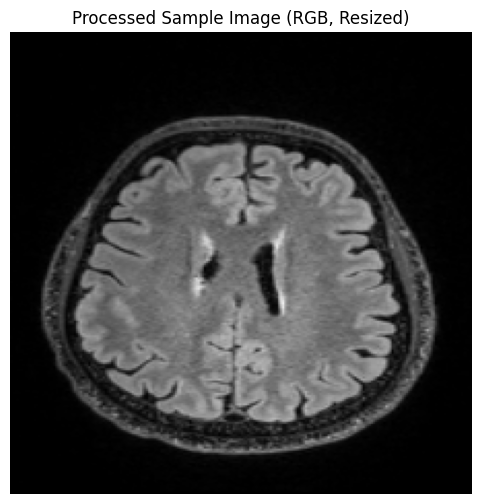

Processed image shape: (224, 224, 3)
Processed image min value: 0
Processed image max value: 240
Processed image dtype: uint8
--- Preprocessing setup complete ---


In [8]:
# Cell 6: Image Preprocessing Function & Test
# ===========================================
print("\n--- Defining Image Preprocessing Function ---")

# Note: Skull stripping could be added here as a more advanced step,
# potentially using libraries like nipype, nilearn, or dedicated models,
# but adds significant complexity. For now, we focus on standard resizing/color.
def preprocess_image(image_path, target_size=IMG_SIZE):
    """Reads, resizes, and converts BGR->RGB image."""
    try:
        img = cv2.imread(str(image_path)) # Ensure path is string
        if img is None:
            # print(f"Warning: Could not read image at {image_path}. Returning None.")
            return None
        img = cv2.resize(img, target_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Keras models expect RGB
        # Normalization is now handled by ImageDataGenerator's rescale parameter
        # img = img.astype(np.float32) / 255.0 # REMOVED
        return img
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

print("Preprocessing function defined.")

# --- Test the function ---
print("\nTesting preprocessing function...")
# Test on the original df, as df_train/df_test might be None if loading failed
if df is not None and not df.empty:
    first_valid_path = None
    for path in df['image_path']:
        if os.path.exists(path):
            first_valid_path = path
            break

    if first_valid_path:
        print(f"Processing sample image: {first_valid_path}")
        sample_img_processed = preprocess_image(first_valid_path)
        if sample_img_processed is not None:
            plt.figure(figsize=(6, 6))
            # Display the image as is (it's now 0-255 uint8)
            plt.imshow(sample_img_processed)
            plt.title("Processed Sample Image (RGB, Resized)")
            plt.axis('off')
            plt.show()
            print(f"Processed image shape: {sample_img_processed.shape}")
            print(f"Processed image min value: {sample_img_processed.min()}")
            print(f"Processed image max value: {sample_img_processed.max()}")
            print(f"Processed image dtype: {sample_img_processed.dtype}") # Should be uint8 now
        else:
            print("Preprocessing failed for the sample image.")
    else:
        print("Could not find a valid image path in the dataframe to test preprocessing.")
else:
    print("DataFrame 'df' not available. Skipping preprocessing test.")

print("--- Preprocessing setup complete ---")

In [9]:
# Cell 7: Data Augmentation and Generators
# =======================================
print("\n--- Setting up Data Augmentation and Generators ---")

# --- Augmentation Setup ---
# Generator for Training data (with augmentation and validation split)
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values to [0, 1]
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest',
    validation_split=VALIDATION_SPLIT_SIZE # Use 20% of df_train for validation
)
print("Train ImageDataGenerator configured with augmentation and rescaling.")

# Generator for Validation data (only rescaling and validation split)
validation_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values to [0, 1]
    validation_split=VALIDATION_SPLIT_SIZE # Must match train_datagen
)
print("Validation ImageDataGenerator configured (rescaling and validation_split).")

# Generator for Test data (only rescaling, no augmentation, no split)
test_datagen = ImageDataGenerator(
    rescale=1./255           # Normalize pixel values to [0, 1]
)
print("Test ImageDataGenerator configured (rescaling only).")


# --- Create Generators ---
train_generator = None
validation_generator = None
test_generator = None

# Use df_train for training and validation sets
if df_train is not None:
    print("\nCreating Train Generator (from df_train)...")
    start_time = time.time()
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=df_train,
        x_col='image_path',
        y_col='diagnosis_str', # Target labels as strings for categorical
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',      # Specify this subset
        shuffle=True,
        seed=SEED
    )
    end_time = time.time()
    print(f"Train Generator created in {end_time - start_time:.2f} seconds.")


    print("\nCreating Validation Generator (from df_train)...")
    start_time = time.time()
    validation_generator = validation_datagen.flow_from_dataframe(
        dataframe=df_train,       # Use train dataframe
        x_col='image_path',
        y_col='diagnosis_str',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',    # Specify this subset
        shuffle=False           # No shuffle for validation
        # seed=SEED # Seed not strictly needed if shuffle=False
    )
    end_time = time.time()
    print(f"Validation Generator created in {end_time - start_time:.2f} seconds.")

else:
    print("Training DataFrame ('df_train') not available. Cannot create train/validation generators.")

# Use df_test for the final test set
if df_test is not None:
    print("\nCreating Test Generator (from df_test)...")
    start_time = time.time()
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=df_test,        # Use test dataframe
        x_col='image_path',
        y_col='diagnosis_str',    # Still need labels for evaluation reference
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,    # Can be same or different, but keep consistent for steps calculation if used
        class_mode='categorical',
        shuffle=False             # No shuffle for testing
        # seed=SEED
    )
    end_time = time.time()
    print(f"Test Generator created in {end_time - start_time:.2f} seconds.")
else:
     print("Test DataFrame ('df_test') not available. Cannot create test generator.")


# Verify generator outputs (optional but recommended)
if train_generator:
    print("\nVerifying generator output shapes and types...")
    sample_batch_x, sample_batch_y = next(train_generator)
    print(f"Sample train batch X shape: {sample_batch_x.shape}")
    print(f"Sample train batch Y shape: {sample_batch_y.shape}")
    print(f"Sample train batch X dtype: {sample_batch_x.dtype}")
    print(f"Sample train batch Y dtype: {sample_batch_y.dtype}")
    print(f"Sample train batch X min/max: {sample_batch_x.min():.4f}/{sample_batch_x.max():.4f}") # Should be approx 0/1
else:
    print("\nTrain generator not available. Skipping output verification.")

print("--- Data Generators setup complete ---")


--- Setting up Data Augmentation and Generators ---
Train ImageDataGenerator configured with augmentation and rescaling.
Validation ImageDataGenerator configured (rescaling and validation_split).
Test ImageDataGenerator configured (rescaling only).

Creating Train Generator (from df_train)...
Found 13775 validated image filenames belonging to 5 classes.
Train Generator created in 28.16 seconds.

Creating Validation Generator (from df_train)...
Found 3443 validated image filenames belonging to 5 classes.
Validation Generator created in 8.05 seconds.

Creating Test Generator (from df_test)...
Found 3039 validated image filenames belonging to 5 classes.
Test Generator created in 5.58 seconds.

Verifying generator output shapes and types...
Sample train batch X shape: (32, 224, 224, 3)
Sample train batch Y shape: (32, 5)
Sample train batch X dtype: float32
Sample train batch Y dtype: float32
Sample train batch X min/max: 0.0000/1.0000
--- Data Generators setup complete ---


In [10]:
# Cell 8: Build the Model (Two-Phase Ready)
# ==========================================
print("\n--- Building Model ---")

def build_resnet50v2_model(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES):
    """Builds a classification model using ResNet50V2 as the base."""
    print(f"Building model with input shape {input_shape} and {num_classes} classes.")
    # Load base model pre-trained on ImageNet
    print("Loading ResNet50V2 base model with ImageNet weights...")
    start_time = time.time()
    base_model = applications.ResNet50V2(
        weights='imagenet',
        include_top=False,     # Exclude the original ImageNet classifier head
        input_shape=input_shape
    )
    end_time = time.time()
    print(f"Base model loaded in {end_time - start_time:.2f} seconds.")

    # Build the full model
    inputs = tf.keras.Input(shape=input_shape, name='input_layer')
    # Set training=False for the base model initially (feature extraction phase)
    # This prevents BatchNorm layers from updating their statistics during this phase
    x = base_model(inputs, training=False)
    print("Base model added (initially frozen).")

    # Custom classification head
    print("Adding custom classification head...")
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.Dense(512, activation='relu', name='dense_head_1')(x)
    x = layers.BatchNormalization(name='batch_norm_head_1')(x)
    x = layers.Dropout(0.5, name='dropout_head_1')(x) # Regularization
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    print("Output layer added.")

    model = models.Model(inputs, outputs, name='alzheimer_resnet50v2')
    print("Model built successfully.")

    return model, base_model # Return both model and base_model reference

# Build the initial model
model, base_model = build_resnet50v2_model()

print("\n--- Initial Model Summary (Base Frozen) ---")
model.summary() # Base model layers should show as non-trainable here
print("--- Model Building complete ---")


--- Building Model ---
Building model with input shape (224, 224, 3) and 5 classes.
Loading ResNet50V2 base model with ImageNet weights...
Base model loaded in 2.51 seconds.
Base model added (initially frozen).
Adding custom classification head...
Output layer added.
Model built successfully.

--- Initial Model Summary (Base Frozen) ---


Model: "alzheimer_resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ avg_pool (GlobalAveragePooling2D)    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_head_1 (Dense)                 │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_norm_head_1                    │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_head_1 (Dropout)             │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predictions (Dense)                  │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,618,501 (93.91 MB)

 Trainable params: 24,572,037 (93.73 MB)

 Non-trainable params: 46,464 (181.50 KB)

--- Model Building complete ---


In [11]:
# Cell 9: Compile and Train (Phase 1 - Head Training) - CORRECTED
# =====================================================
print("\n--- Training Phase 1: Feature Extraction (Train Head) ---")

# --- Configure Callbacks for Phase 1 ---
print("Configuring callbacks...")
# Use slightly different patience maybe, or reuse
early_stopping_p1 = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True) # Shorter patience for head
reduce_lr_p1 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=1e-6) # Allow slightly higher min_lr
model_checkpoint_p1 = ModelCheckpoint(MODEL_CHECKPOINT_PATH, monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1)

callbacks_phase1 = [early_stopping_p1, reduce_lr_p1, model_checkpoint_p1]
print("Callbacks configured for Phase 1.")

# --- Compile for Phase 1 ---
print("\nCompiling model for Phase 1...")
base_model.trainable = False # Ensure base is frozen
optimizer_phase1 = optimizers.Adam(learning_rate=LEARNING_RATE_PHASE1)
model.compile(
    optimizer=optimizer_phase1,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print("Model compiled.")
print(f"Confirming base model trainable status: {base_model.trainable}")
print(f"Number of trainable weights in base model: {len(base_model.trainable_weights)}") # Should be 0

# --- Train Phase 1 ---
history_phase1 = None
if train_generator and validation_generator:
    print("\nStarting Phase 1 training...")
    start_time = time.time()
    history_phase1 = model.fit(
        train_generator,
        epochs=EPOCHS_PHASE1,
        validation_data=validation_generator,
        callbacks=callbacks_phase1,
        # class_weight=class_weights_dict, # REMOVED
        # REMOVE steps_per_epoch=max(1, train_generator.samples // BATCH_SIZE),
        # REMOVE validation_steps=max(1, validation_generator.samples // BATCH_SIZE)
        # Let Keras infer the steps from the generator length
    )
    end_time = time.time()
    print(f"--- Phase 1 training finished in {(end_time - start_time)/60:.2f} minutes ---")
else:
    print("Generators not available. Skipping Phase 1 training.")

print("--- Phase 1 complete ---")


--- Training Phase 1: Feature Extraction (Train Head) ---
Configuring callbacks...
Callbacks configured for Phase 1.

Compiling model for Phase 1...
Model compiled.
Confirming base model trainable status: False
Number of trainable weights in base model: 0

Starting Phase 1 training...
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


430/431 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.3639 - loss: 1.7990
Epoch 1: val_accuracy improved from -inf to 0.51322, saving model to /kaggle/working/resnet50v2_adni_best.keras
431/431 ━━━━━━━━━━━━━━━━━━━━ 286s 626ms/step - accuracy: 0.3641 - loss: 1.7978 - val_accuracy: 0.5132 - val_loss: 1.1618 - learning_rate: 0.0010
Epoch 2/15
430/431 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.4648 - loss: 1.2467
Epoch 2: val_accuracy improved from 0.51322 to 0.52977, saving model to /kaggle/working/resnet50v2_adni_best.keras
431/431 ━━━━━━━━━━━━━━━━━━━━ 207s 473ms/step - accuracy: 0.4648 - loss: 1.2466 - val_accuracy: 0.5298 - val_loss: 1.0841 - learning_rate: 0.0010
Epoch 3/15
430/431 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.5122 - loss: 1.1230
Epoch 3: val_accuracy did not improve from 0.52977
431/431 ━━━━━━━━━━━━━━━━━━━━ 200s 457ms/step - accuracy: 0.5122 - loss: 1.1229 - val_accuracy: 0.4970 - val_loss: 1.1337 - learning_rate: 0.0010
Epoch 4/15
430/431 ━━━━━━━━━━━━━━━

In [13]:
# Cell 1: Setup and Imports (Add this line)
# ... other imports ...
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers, backend as K # <-- ADD ", backend as K"
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# ... rest of imports ...

In [14]:
# Cell 10: Compile and Train (Phase 2 - Fine-Tuning)
# ===================================================
print("\n--- Training Phase 2: Fine-Tuning ---")

# --- Load Best Weights from Phase 1 ---
print(f"\nLoading best model from Phase 1 checkpoint: {MODEL_CHECKPOINT_PATH}")
# Keep track if loading succeeded for conditional execution later
model_loaded_successfully = False
if os.path.exists(MODEL_CHECKPOINT_PATH):
    try:
        # Load the whole model saved by ModelCheckpoint
        model = load_model(MODEL_CHECKPOINT_PATH)
        # Re-establish reference to the base model layer
        base_model_layer_found = False
        for layer in model.layers:
             # Use the actual name Keras likely assigned
             if layer.name == base_model.name: # Find by name
                 base_model = layer
                 base_model_layer_found = True
                 print(f"Base model layer '{base_model.name}' found.")
                 break
        if not base_model_layer_found:
             print(f"Warning: Could not find layer named '{base_model.name}'. This might affect fine-tuning.")
             # Attempt fallback if structure is known (less robust)
             # base_model = model.layers[1]

        print("Best model from Phase 1 loaded successfully.")
        model_loaded_successfully = True

    except Exception as e:
        print(f"Could not load best weights from {MODEL_CHECKPOINT_PATH}. Error: {e}")
        print("Proceeding with current weights (end of Phase 1).")
        # Ensure base_model reference is still valid if loading failed but model object exists
        if 'model' not in locals() or not hasattr(model, 'layers'):
             print("ERROR: Cannot proceed without a valid model object.")
             model = None # Prevent further execution
        model_loaded_successfully = False # Mark as not loaded from checkpoint
else:
    print(f"Checkpoint file not found at {MODEL_CHECKPOINT_PATH}. Cannot load best weights.")
    print("Proceeding with current weights (end of Phase 1), if available.")
    if 'model' not in locals():
         print("ERROR: Cannot proceed without a valid model object.")
         model = None
    model_loaded_successfully = False # Mark as not loaded from checkpoint


# --- Configure Callbacks for Phase 2 ---
# Increase patience slightly for fine-tuning
early_stopping_p2 = EarlyStopping(monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
reduce_lr_p2 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-7)
# Checkpoint saves the best model found across BOTH phases if loading worked
model_checkpoint_p2 = ModelCheckpoint(MODEL_CHECKPOINT_PATH, monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1)

callbacks_phase2 = [early_stopping_p2, reduce_lr_p2, model_checkpoint_p2]
print("\nCallbacks configured for Phase 2.")


# --- Compile for Phase 2 ---
history_phase2 = None
# Proceed only if model exists, generators exist, and phase 1 history exists (meaning phase 1 ran)
if model and train_generator and validation_generator and history_phase1:
    print("\nUnfreezing layers for fine-tuning...")
    base_model.trainable = True # Unfreeze the base model first

    # Freeze layers *before* FINE_TUNE_AT_LAYER
    print(f"Fine-tuning from layer index {FINE_TUNE_AT_LAYER} ('{base_model.layers[FINE_TUNE_AT_LAYER].name}') onwards.")
    for layer in base_model.layers[:FINE_TUNE_AT_LAYER]:
       layer.trainable = False

    print("\nRe-compiling model for Phase 2 with low learning rate...")
    optimizer_phase2 = optimizers.Adam(learning_rate=LEARNING_RATE_PHASE2) # Very low LR
    model.compile(
        optimizer=optimizer_phase2,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    print("Model re-compiled.")
    print(f"Confirming base model trainable status: {base_model.trainable}")
    # Count trainable weights AFTER recompiling and setting layer trainability
    trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])
    print(f"Total Trainable params: {trainable_count}")
    print(f"Total Non-trainable params: {non_trainable_count}")


    # --- Train Phase 2 ---
    print("\nStarting Phase 2 training (fine-tuning)...")
    start_time = time.time()
    # Determine starting epoch
    initial_epoch_p2 = len(history_phase1.epoch) if history_phase1 else 0 # Number of epochs completed in Phase 1
    total_epochs = initial_epoch_p2 + EPOCHS_PHASE2
    print(f"Continuing training from epoch {initial_epoch_p2} up to {total_epochs}")

    history_phase2 = model.fit(
        train_generator,
        epochs=total_epochs,                      # Total epochs to reach
        initial_epoch=initial_epoch_p2,           # Start from here
        validation_data=validation_generator,
        callbacks=callbacks_phase2
        # class_weight=class_weights_dict, # Not using class weights
    )
    end_time = time.time()
    print(f"--- Phase 2 training finished in {(end_time - start_time)/60:.2f} minutes ---")

elif not history_phase1:
     print("Phase 1 history not available. Skipping Phase 2 training.")
else:
    print("Model or generators not available. Skipping Phase 2 training.")

print("--- Phase 2 complete ---")


--- Training Phase 2: Fine-Tuning ---

Loading best model from Phase 1 checkpoint: /kaggle/working/resnet50v2_adni_best.keras
Base model layer 'resnet50v2' found.
Best model from Phase 1 loaded successfully.

Callbacks configured for Phase 2.

Unfreezing layers for fine-tuning...
Fine-tuning from layer index 150 ('conv4_block6_2_relu') onwards.

Re-compiling model for Phase 2 with low learning rate...
Model re-compiled.
Confirming base model trainable status: True
Total Trainable params: 16286725
Total Non-trainable params: 8331776

Starting Phase 2 training (fine-tuning)...
Continuing training from epoch 15 up to 55
Epoch 16/55
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.4737 - loss: 1.3887
Epoch 16: val_accuracy improved from -inf to 0.56695, saving model to /kaggle/working/resnet50v2_adni_best.keras
431/431 ━━━━━━━━━━━━━━━━━━━━ 244s 513ms/step - accuracy: 0.4738 - loss: 1.3883 - val_accuracy: 0.5669 - val_loss: 0.9812 - learning_rate: 1.0000e-05
Epoch 17/55
431/431 ━━━


--- Plotting Training History ---
Plotting combined history for Phase 1 and Phase 2.


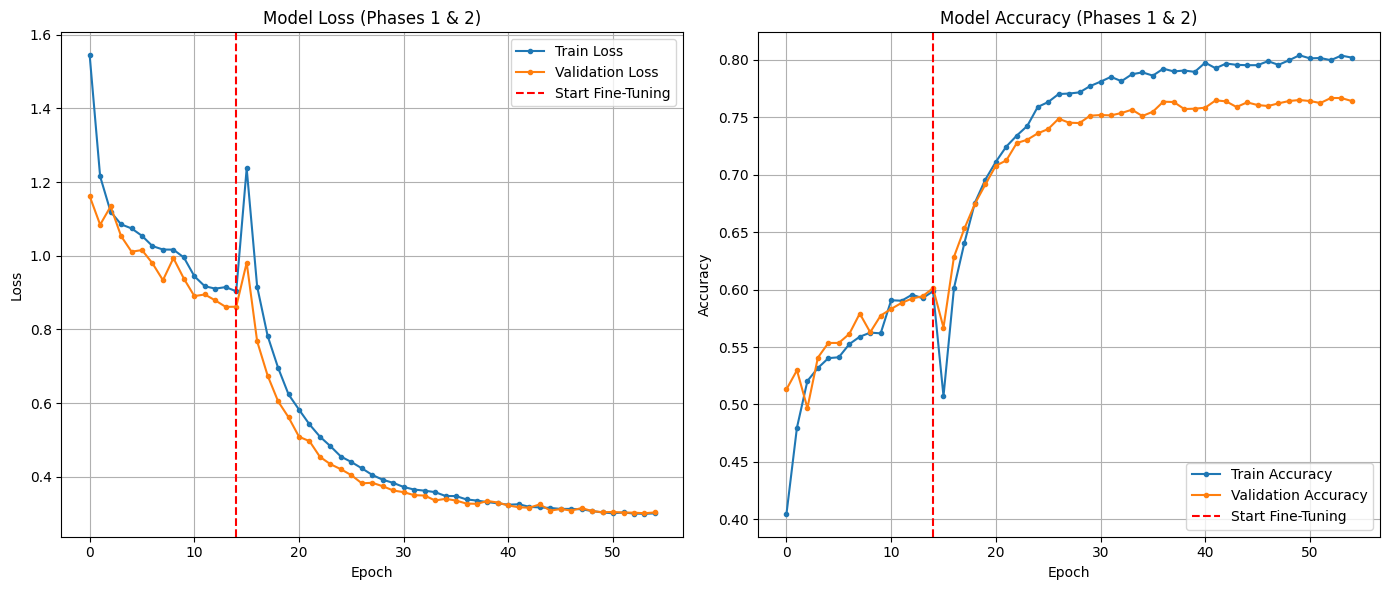

--- History Plotting complete ---


In [15]:
# Cell 11: Plot Training History (Combined)
# ==========================================
print("\n--- Plotting Training History ---")

# Combine histories if both phases ran
if history_phase1 and history_phase2:
    print("Plotting combined history for Phase 1 and Phase 2.")
    combined_history = {}
    for key in history_phase1.history.keys():
        combined_history[key] = history_phase1.history[key] + history_phase2.history[key]

    epochs_phase1_actual = len(history_phase1.history['loss'])
    epochs_total = len(combined_history['loss'])
    epoch_range = range(epochs_total)

    plt.figure(figsize=(14, 6))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epoch_range, combined_history['loss'], label='Train Loss', marker='.')
    plt.plot(epoch_range, combined_history['val_loss'], label='Validation Loss', marker='.')
    plt.axvline(x=epochs_phase1_actual - 1, color='r', linestyle='--', label='Start Fine-Tuning')
    plt.title("Model Loss (Phases 1 & 2)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epoch_range, combined_history['accuracy'], label='Train Accuracy', marker='.')
    plt.plot(epoch_range, combined_history['val_accuracy'], label='Validation Accuracy', marker='.')
    plt.axvline(x=epochs_phase1_actual - 1, color='r', linestyle='--', label='Start Fine-Tuning')
    plt.title("Model Accuracy (Phases 1 & 2)")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

elif history_phase1: # Only phase 1 completed
     print("Plotting history for Phase 1 only.")
     epochs_phase1_actual = len(history_phase1.history['loss'])
     epoch_range = range(epochs_phase1_actual)
     plt.figure(figsize=(14, 6))

     plt.subplot(1, 2, 1)
     plt.plot(epoch_range, history_phase1.history['loss'], label='Train Loss', marker='.')
     plt.plot(epoch_range, history_phase1.history['val_loss'], label='Validation Loss', marker='.')
     plt.title("Model Loss (Phase 1)")
     plt.xlabel("Epoch")
     plt.ylabel("Loss")
     plt.legend()
     plt.grid(True)

     plt.subplot(1, 2, 2)
     plt.plot(epoch_range, history_phase1.history['accuracy'], label='Train Accuracy', marker='.')
     plt.plot(epoch_range, history_phase1.history['val_accuracy'], label='Validation Accuracy', marker='.')
     plt.title("Model Accuracy (Phase 1)")
     plt.xlabel("Epoch")
     plt.ylabel("Accuracy")
     plt.legend()
     plt.grid(True)

     plt.tight_layout()
     plt.show()
else:
    print("No training history available to plot.")

print("--- History Plotting complete ---")

In [16]:
# Cell 12: Evaluate the Best Model
# =================================
print("\n--- Evaluating Best Model ---")
best_model = None
if os.path.exists(MODEL_CHECKPOINT_PATH):
    print(f"Loading best model saved during training from: {MODEL_CHECKPOINT_PATH}")
    try:
        # Load the entire model saved by ModelCheckpoint during fine-tuning
        best_model = load_model(MODEL_CHECKPOINT_PATH)
        print("Best model loaded successfully.")
    except Exception as e:
        print(f"ERROR: Could not load best model from {MODEL_CHECKPOINT_PATH}. Error: {e}")
else:
    print(f"ERROR: Checkpoint file not found at {MODEL_CHECKPOINT_PATH}. Cannot evaluate the best model.")
    print("You might need to re-run training or check the MODEL_SAVE_DIR path.")

# --- Evaluation ---
# Evaluate on the DEDICATED test_generator now
if best_model and test_generator:
    print("\nEvaluating best model on the dedicated test set...")
    start_time = time.time()
    # Calculate steps to cover the entire test set
    test_steps = np.ceil(test_generator.samples / BATCH_SIZE)
    test_loss, test_accuracy = best_model.evaluate(test_generator, steps=test_steps)
    end_time = time.time()
    print(f"Evaluation completed in {end_time - start_time:.2f} seconds.")
    print(f"\nTest Loss (Best Model): {test_loss:.4f}")
    print(f"Test Accuracy (Best Model): {test_accuracy:.4f}")

    # --- Detailed Report and Confusion Matrix ---
    print("\nGenerating predictions for detailed report...")
    test_generator.reset() # IMPORTANT: Reset generator before predicting
    start_time = time.time()
    # Use enough steps to predict on all test samples
    y_pred_probs = best_model.predict(test_generator, steps=test_steps)
    end_time = time.time()
    print(f"Predictions generated in {end_time - start_time:.2f} seconds.")

    # Ensure lengths match - Get true labels from the test generator
    num_samples = test_generator.samples
    y_true = test_generator.classes[:num_samples] # Get true classes in order
    y_pred_probs = y_pred_probs[:num_samples] # Trim if predict generated extra
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    print(f"Length of y_true (test set): {len(y_true)}")
    print(f"Length of y_pred_classes (test set): {len(y_pred_classes)}")

    if len(y_true) == len(y_pred_classes):
        print("\nClassification Report (Best Model on Test Set):")
        # Use the class_names defined in config
        print(classification_report(y_true, y_pred_classes, target_names=class_names, zero_division=0))

        print("\nConfusion Matrix (Best Model on Test Set):")
        cm = confusion_matrix(y_true, y_pred_classes)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.title("Confusion Matrix (Best Model on Test Set)")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()
    else:
        print(f"ERROR: Length mismatch between true labels ({len(y_true)}) and predicted labels ({len(y_pred_classes)}). Cannot generate report/matrix.")

else:
    print("\nBest model or Test generator not available. Skipping evaluation.")

print("--- Evaluation complete ---")


--- Evaluating Best Model ---
Loading best model saved during training from: /kaggle/working/resnet50v2_adni_best.keras
Best model loaded successfully.

Evaluating best model on the dedicated test set...


TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [ ]:
# Cell 13: Single Image Prediction Test
# ======================================
print("\n--- Single Image Prediction Test ---")

# Modified function to use rescaling consistent with generators
def predict_single_image_rescaled(image_path, model_to_use, class_map=diagnosis_mapping, target_size=IMG_SIZE):
    """Preprocesses (resize, BGR->RGB, rescale) and predicts."""
    print(f"Predicting image: {image_path}")
    if not os.path.exists(image_path):
        print(f"Error: Image path does not exist: {image_path}")
        return None
    try:
        img = cv2.imread(str(image_path))
        if img is None:
            return None
        img = cv2.resize(img, target_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) * (1./255) # Apply rescaling like generator

        img_batch = np.expand_dims(img, axis=0) # Add batch dimension

        predictions = model_to_use.predict(img_batch)
        predicted_class_index = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class_index]
        predicted_class_name = class_map.get(predicted_class_index, "Unknown")
        probabilities = {class_map.get(i, "Unknown"): prob for i, prob in enumerate(predictions[0])}
        return {
            'predicted_class': predicted_class_name,
            'confidence': confidence,
            'probabilities': probabilities,
            'preprocessed_image': img # Return the rescaled image
        }
    except Exception as e:
        print(f"Error during prediction or preprocessing: {e}")
        return None

# --- Test Prediction ---
if df_test is not None and not df_test.empty and best_model: # Use df_test now
    # Select a sample image path from the test set
    sample_idx_in_df_test = 50 # Example index within df_test
    if sample_idx_in_df_test < len(df_test):
        sample_image_path = df_test['image_path'].iloc[sample_idx_in_df_test]
        true_label_name = df_test['class_name'].iloc[sample_idx_in_df_test]
        print(f"Selected sample image from test dataframe: {sample_image_path}")
        print(f"True Label: {true_label_name}")
    else:
         print(f"Warning: Sample index {sample_idx_in_df_test} out of bounds for test dataframe.")
         sample_image_path = None # Indicate failure

    if sample_image_path:
        # Use the loaded best_model for prediction
        start_time = time.time()
        # Use the modified prediction function
        result = predict_single_image_rescaled(sample_image_path, best_model)
        end_time = time.time()
        print(f"Single prediction took {end_time - start_time:.4f} seconds.")

        if result:
            print(f"\nPredicted Class: {result['predicted_class']}")
            print(f"Confidence: {result['confidence']:.4f}")
            print("\nClass Probabilities:")
            for class_name, prob in sorted(result['probabilities'].items(), key=lambda item: item[1], reverse=True):
                print(f"  {class_name}: {prob:.4f}")

            # Display original and preprocessed image
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            try:
                orig_img = cv2.imread(sample_image_path)
                orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
                plt.imshow(orig_img)
                plt.title(f"Original Image\nTrue: {true_label_name}")
                plt.axis('off')
            except Exception as e:
                print(f"Could not display original image: {e}")

            plt.subplot(1, 2, 2)
            # Display the preprocessed image (should be 0-1 float now)
            plt.imshow(result['preprocessed_image'])
            plt.title(f"Preprocessed Image (Rescaled)\nPredicted: {result['predicted_class']}")
            plt.axis('off')
            plt.tight_layout()
            plt.show()
        else:
            print("Prediction failed for the sample image.")
else:
    print("Test DataFrame 'df_test', or best_model not available. Cannot perform prediction test.")

print("--- Single Image Prediction complete ---")

In [20]:
# Cell 14: Interactive Single Image Prediction Test
# ==================================================
print("\n--- Interactive Single Image Prediction Test ---")

# Prompt the user for the image path
# Example path format (Windows): D:/adni_traininhig/ADNI_IMAGES/png_images/CN/CN-0004.png
# Example path format (Linux/Colab): /content/ADNI_IMAGES/png_images/CN/CN-0004.png
user_image_path = input("Enter the full path to an ADNI image: ")

if best_model:
    # Use the rescaled prediction function
    result = predict_single_image_rescaled(user_image_path, best_model)

    if result:
        print(f"\nPredicted Class: {result['predicted_class']}")
        print(f"Confidence: {result['confidence']:.4f}")
        print("\nClass Probabilities:")
        for class_name, prob in sorted(result['probabilities'].items(), key=lambda item: item[1], reverse=True):
            print(f"  {class_name}: {prob:.4f}")

        # Display original and preprocessed image
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        try:
            orig_img = cv2.imread(user_image_path)
            if orig_img is not None:
                orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
                plt.imshow(orig_img)
                plt.title("Original Image")
                plt.axis('off')
            else:
                print(f"Could not read original image at: {user_image_path}")
                plt.title("Original Image (Load Failed)")
                plt.axis('off')
        except Exception as e:
            print(f"Could not display original image: {e}")
            plt.title("Original Image (Error)")
            plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(result['preprocessed_image'])
        plt.title(f"Preprocessed Image\nPredicted: {result['predicted_class']}")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("Prediction failed for the input image.")
else:
    print("Best model not loaded. Cannot perform interactive prediction.")

print("--- Interactive Single Image Prediction complete ---")


--- Interactive Single Image Prediction Test ---
Predicting image: AD
Error: Image path does not exist: AD
Prediction failed for the input image.
--- Interactive Single Image Prediction complete ---
